In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.fft import irfft, rfft, rfftfreq
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import os
import pywt
from scipy.ndimage import gaussian_filter1d, maximum_filter
from scipy.signal import find_peaks

from helper_funcs import *
from findpeaks import findpeaks

In [2]:
# First navigate to our directory
directory_path = os.path.join("Data", "processed_df.parquet")
# Load the dataframe
df = pd.read_parquet(directory_path)
# Get frequncy axis
f = rfftfreq(32768, 1/44100)[0:8192]

In [7]:
index = 2000
spectrum = df.iloc[index]['spectrum']
spectrum = np.copy(spectrum)

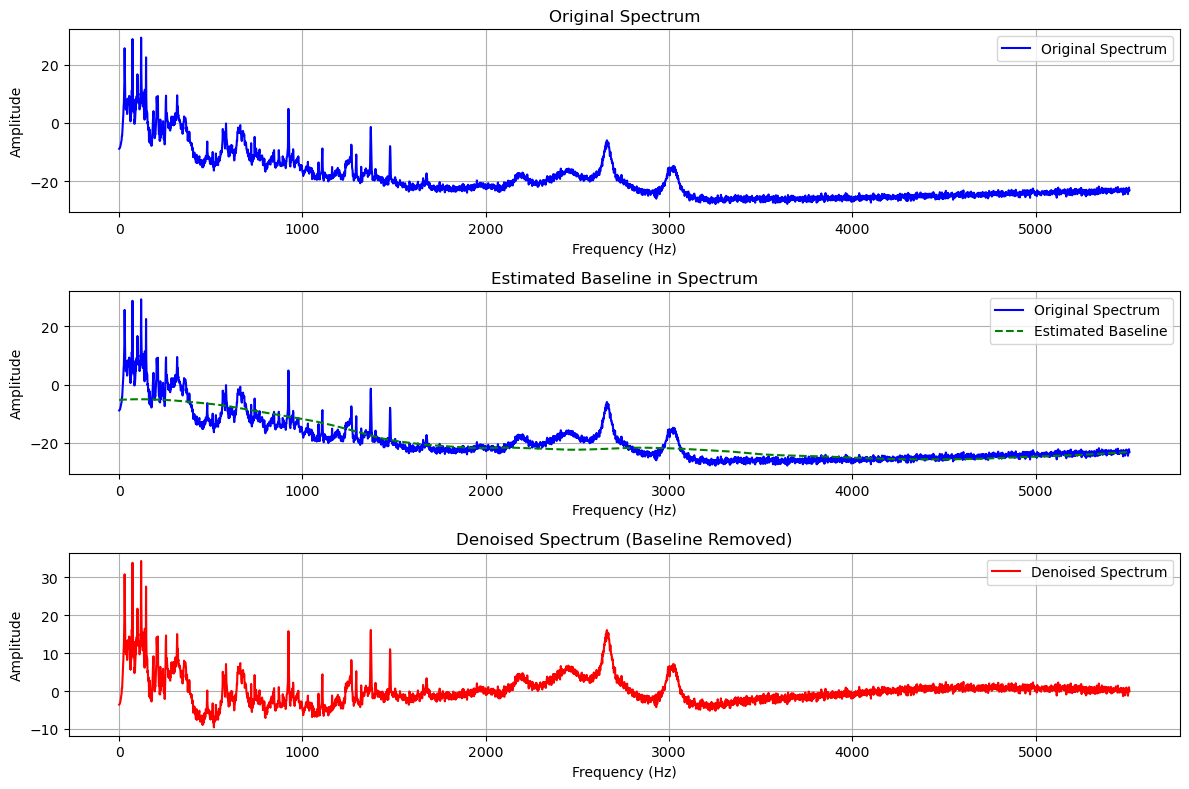

In [8]:
# Wavelet decomposition of spectrum for baseline estimation

freqs = f

# Function to perform wavelet-based baseline removal in the frequency domain
def wavelet_baseline_removal_spectrum(spectrum, wavelet='db4', level=None):
    """
    Removes baseline noise from a frequency-domain spectrum using wavelet decomposition.
    
    Parameters:
        spectrum (numpy array): Input spectrum (Fourier-transformed signal).
        wavelet (str): Wavelet type (default 'db4').
        level (int): Decomposition level (default: maximum level).
    
    Returns:
        baseline (numpy array): Estimated baseline in the spectrum.
        denoised_spectrum (numpy array): Spectrum after baseline removal.
    """
    # Perform wavelet decomposition
    max_level = pywt.dwt_max_level(len(spectrum), pywt.Wavelet(wavelet).dec_len)
    level = level if level else max_level  # Use maximum level if not specified
    coeffs = pywt.wavedec(spectrum, wavelet, level=level)
    
    # Retain only the approximation coefficients (low-frequency components)
    baseline_coeffs = [coeffs[0]] + [None] * level
    baseline = pywt.waverec(baseline_coeffs, wavelet)
    baseline = baseline[:len(spectrum)]  # Ensure baseline matches spectrum length
    
    # Subtract baseline from spectrum
    denoised_spectrum = spectrum - baseline
    return baseline, denoised_spectrum

# Apply wavelet-based baseline removal in the frequency domain
baseline_estimate, denoised_spectrum = wavelet_baseline_removal_spectrum(spectrum)

# Plot the original spectrum, baseline, and corrected spectrum
plt.figure(figsize=(12, 8))

# Original spectrum
plt.subplot(3, 1, 1)
plt.plot(freqs[:len(freqs)//2], spectrum[:len(freqs)//2], label='Original Spectrum', color='b')
plt.title('Original Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

# Estimated baseline
plt.subplot(3, 1, 2)
plt.plot(freqs[:len(freqs)//2], spectrum[:len(freqs)//2], label='Original Spectrum', color='b')
plt.plot(freqs[:len(freqs)//2], baseline_estimate[:len(freqs)//2], label='Estimated Baseline', color='g', linestyle='--')
plt.title('Estimated Baseline in Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

# Denoised spectrum
plt.subplot(3, 1, 3)
plt.plot(freqs[:len(freqs)//2], denoised_spectrum[:len(freqs)//2], label='Denoised Spectrum', color='r')
plt.title('Denoised Spectrum (Baseline Removed)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


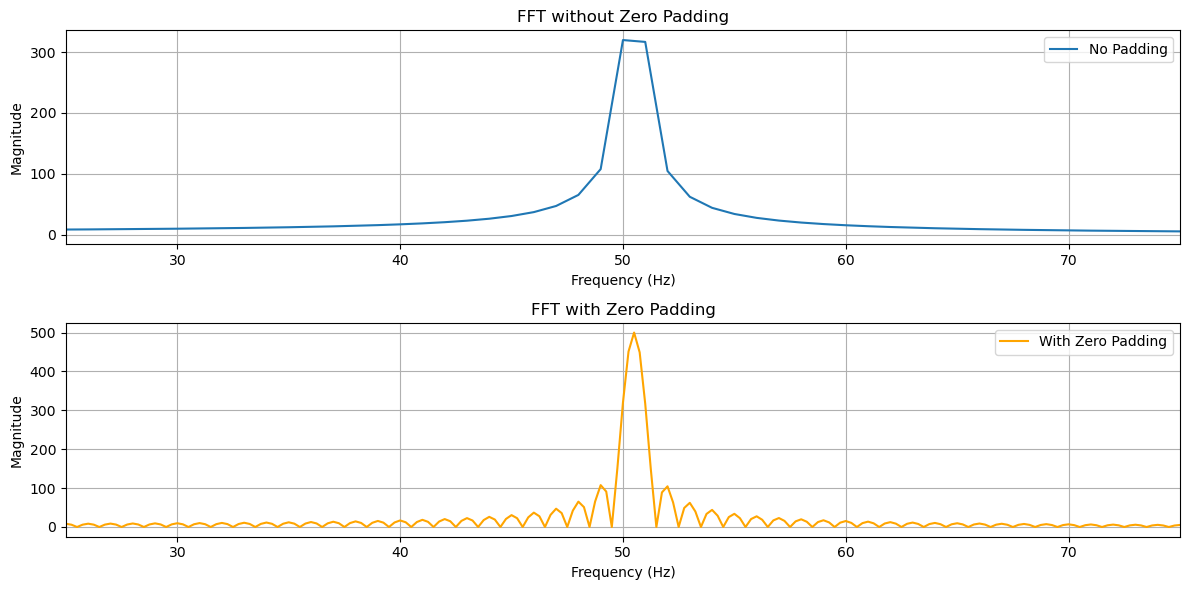

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Create a sinusoidal signal
fs = 1000  # Sampling frequency
t = np.linspace(0, 1, fs, endpoint=False)  # Time vector (1 second)
freq = 50.5 # Frequency of the sinusoid
signal = np.sin(2 * np.pi * freq * t)

# Perform FFT without zero padding
fft_no_padding = np.fft.fft(signal)
freq_no_padding = np.fft.fftfreq(len(signal), d=1/fs)

# Zero-pad the signal to 4x its original length
zero_padded_signal = np.pad(signal, (0, 3 * len(signal)), 'constant')
fft_with_padding = np.fft.fft(zero_padded_signal)
freq_with_padding = np.fft.fftfreq(len(zero_padded_signal), d=1/fs)

# Plot the results
plt.figure(figsize=(12, 6))

# Spectrum without zero padding
plt.subplot(2, 1, 1)
plt.plot(freq_no_padding[:len(freq_no_padding)//2], np.abs(fft_no_padding)[:len(freq_no_padding)//2], label="No Padding")
plt.title("FFT without Zero Padding")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(25, 75)
plt.legend()
plt.grid()

# Spectrum with zero padding
plt.subplot(2, 1, 2)
plt.plot(freq_with_padding[:len(freq_with_padding)//2], np.abs(fft_with_padding)[:len(freq_with_padding)//2], label="With Zero Padding", color='orange')
plt.title("FFT with Zero Padding")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(25, 75)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [101]:
# Original frequency axis and spectrum in dB
freq = freqs  # Original frequency axis
spectrum_dB = spectrum  # Original spectrum in dB

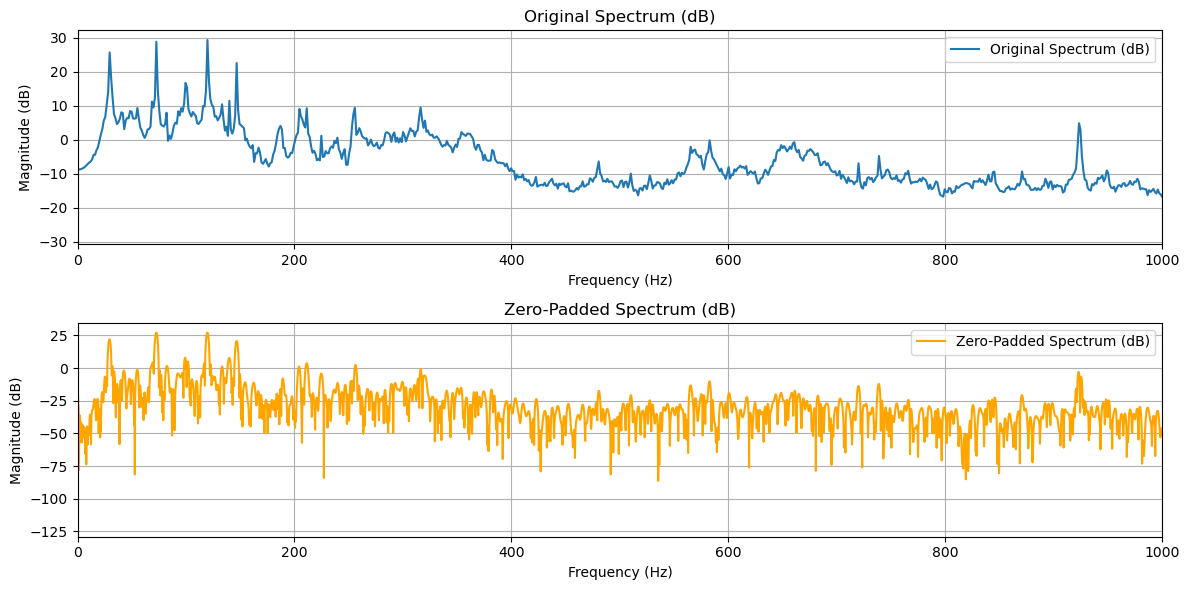

In [ ]:

from scipy.signal.windows import flattop, hann

# Convert spectrum from dB to linear scale
spectrum_linear = 10 ** (spectrum_dB / 20)

# Perform IFFT on the linear spectrum
time_domain_signal = np.fft.ifft(spectrum_linear)

window = hann(len(time_domain_signal))
windowed_signal = time_domain_signal * window
normalized_windowed_signal = time_domain_signal * window / np.mean(window)

# Zero pad the time-domain signal
zero_padding_factor = 4

# Increase length by a factor of 4
zero_padded_signal = np.pad(normalized_windowed_signal, (0, int((zero_padding_factor - 1) * len(time_domain_signal))), 'constant')

# Perform FFT on the zero-padded signal
fft_zero_padded = np.fft.fft(zero_padded_signal)

# Convert the zero-padded spectrum back to dB
spectrum_zero_padded_dB = 20 * np.log10(np.abs(fft_zero_padded))

# Generate the correct frequency axis for the zero-padded spectrum
delta_f = freq[1] - freq[0]  # Original frequency resolution
freq_zero_padded = np.fft.fftfreq(len(zero_padded_signal), d=1 / (len(freq) * delta_f))

# Keep only the positive frequencies for plotting
positive_indices = freq_zero_padded >= 0
freq_zero_padded = freq_zero_padded[positive_indices]
spectrum_zero_padded_dB_positive = spectrum_zero_padded_dB[positive_indices]

# Plot the original and zero-padded spectra
plt.figure(figsize=(12, 6))

# Original spectrum
plt.subplot(2, 1, 1)
plt.plot(freq, spectrum_dB, label="Original Spectrum (dB)")
plt.title("Original Spectrum (dB)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(0, 1000)
plt.legend()
plt.grid()

# Zero-padded spectrum
plt.subplot(2, 1, 2)
plt.plot(freq_zero_padded, spectrum_zero_padded_dB_positive, label="Zero-Padded Spectrum (dB)", color="orange")
plt.title("Zero-Padded Spectrum (dB)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(0, 1000)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


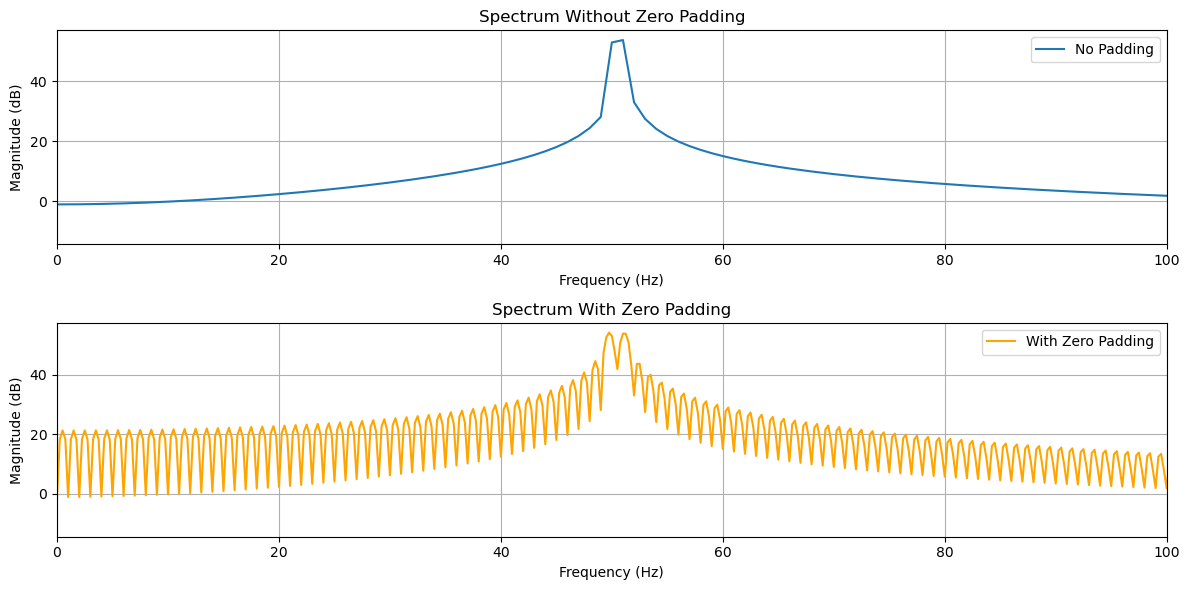

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Create a signal with two very closely spaced frequencies
fs = 1000  # Sampling frequency
T = 1  # Signal duration (1 second)
t = np.linspace(0, T, int(fs * T), endpoint=False)  # Time vector

# Two frequencies, separated by less than 1/T
f1 = 50
f2 = 50.9
A = 1
signal = A*np.sin(2 * np.pi * f1 * t) + A*np.sin(2 * np.pi * f2 * t)

# Perform FFT without zero padding
fft_no_padding = np.fft.fft(signal)
freq_no_padding = np.fft.fftfreq(len(signal), d=1/fs)
spectrum_no_padding_dB = 20 * np.log10(np.abs(fft_no_padding) + 1e-12)  # Convert to dB

# Perform FFT with zero padding (4x the original length)
zero_padding_factor = 4
zero_padded_signal = np.pad(signal, (0, (zero_padding_factor - 1) * len(signal)), 'constant')
fft_zero_padded = np.fft.fft(zero_padded_signal)
freq_zero_padded = np.fft.fftfreq(len(zero_padded_signal), d=1/fs)
spectrum_zero_padded_dB = 20 * np.log10(np.abs(fft_zero_padded) + 1e-12)  # Convert to dB

# Plot the results
plt.figure(figsize=(12, 6))

# Spectrum without zero padding
plt.subplot(2, 1, 1)
plt.plot(freq_no_padding[:len(freq_no_padding)//2], spectrum_no_padding_dB[:len(freq_no_padding)//2], label="No Padding")
plt.title("Spectrum Without Zero Padding")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(0, 100)
plt.legend()
plt.grid()

# Spectrum with zero padding
plt.subplot(2, 1, 2)
plt.plot(freq_zero_padded[:len(freq_zero_padded)//2], spectrum_zero_padded_dB[:len(freq_zero_padded)//2], label="With Zero Padding", color="orange")
plt.title("Spectrum With Zero Padding")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(0, 100)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


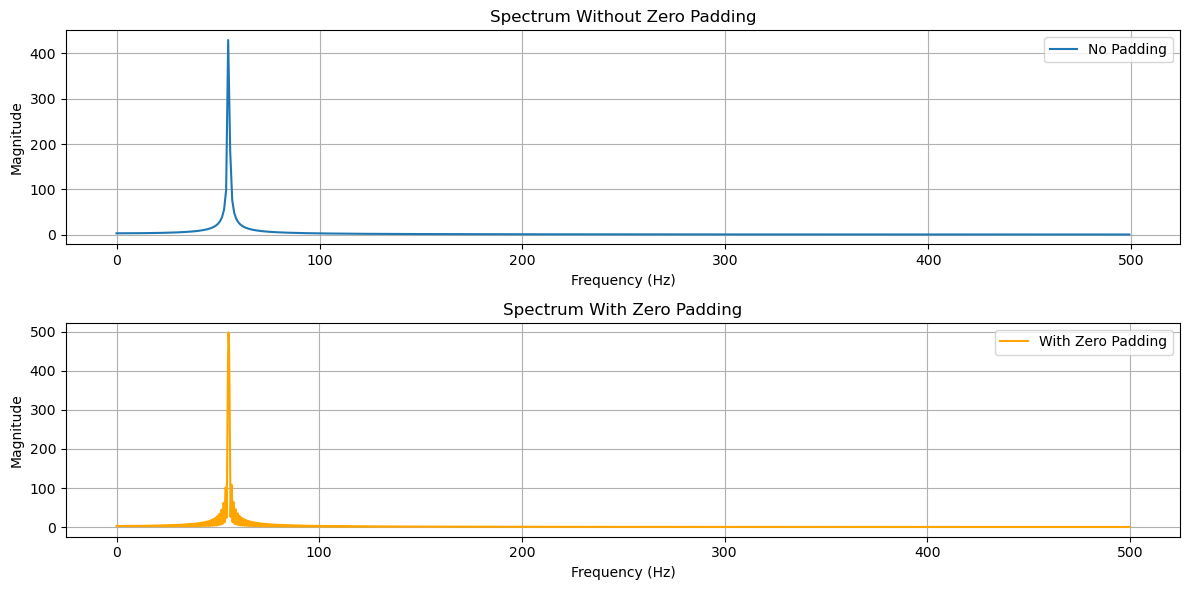

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Create a sinusoidal signal
fs = 1000  # Sampling frequency
T = 1  # Signal duration (1 second)
t = np.linspace(0, T, int(fs * T), endpoint=False)  # Time vector
f_signal = 55.3  # Signal frequency (not aligned with FFT bin)
signal = np.sin(2 * np.pi * f_signal * t)

# Perform FFT without zero padding
fft_no_padding = np.fft.fft(signal)
freq_no_padding = np.fft.fftfreq(len(signal), d=1/fs)

# Perform FFT with zero padding (4x the original length)
zero_padding_factor = 4
zero_padded_signal = np.pad(signal, (0, (zero_padding_factor - 1) * len(signal)), 'constant')
fft_zero_padded = np.fft.fft(zero_padded_signal)
freq_zero_padded = np.fft.fftfreq(len(zero_padded_signal), d=1/fs)

# Plot the results
plt.figure(figsize=(12, 6))

# Spectrum without zero padding
plt.subplot(2, 1, 1)
plt.plot(freq_no_padding[:len(freq_no_padding)//2], np.abs(fft_no_padding)[:len(freq_no_padding)//2], label="No Padding")
plt.title("Spectrum Without Zero Padding")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()

# Spectrum with zero padding
plt.subplot(2, 1, 2)
plt.plot(freq_zero_padded[:len(freq_zero_padded)//2], np.abs(fft_zero_padded)[:len(freq_zero_padded)//2], label="With Zero Padding", color="orange")
plt.title("Spectrum With Zero Padding")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


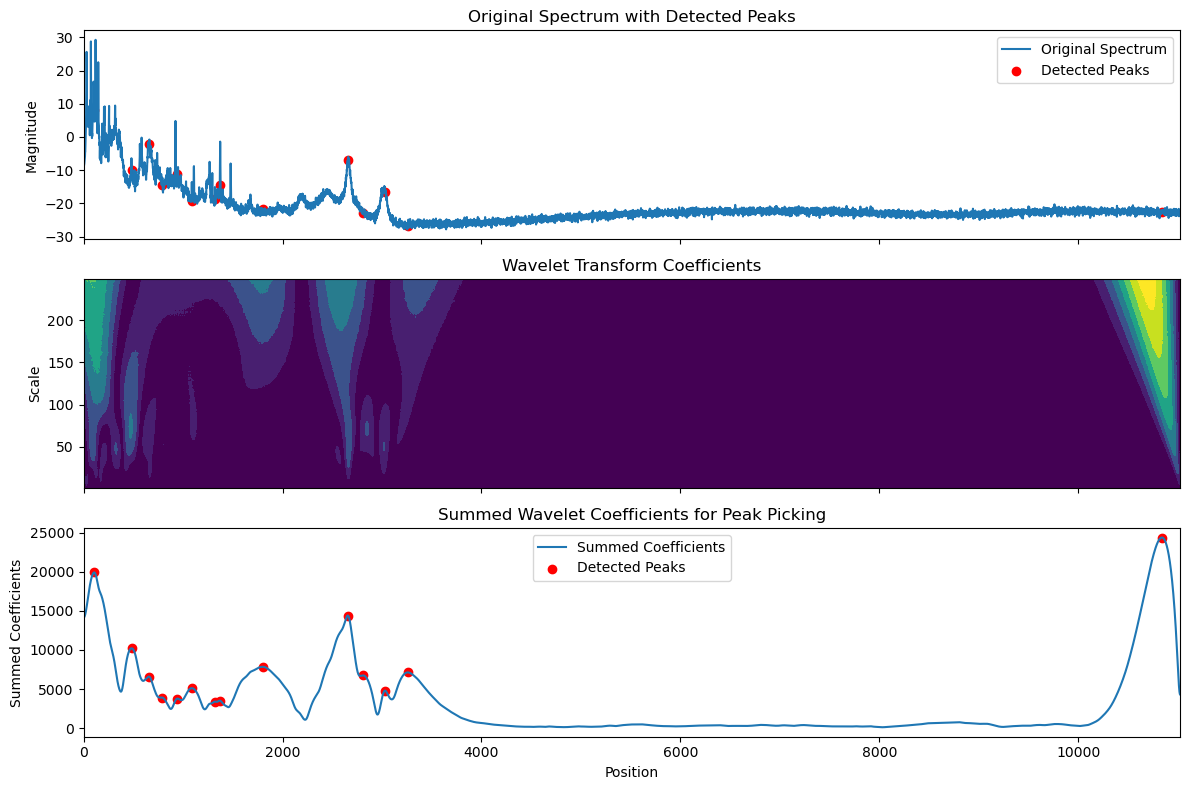

Detected peak positions: [  106.32019043   481.80541992   656.76269531   784.61608887
   943.42346191  1086.08093262  1321.6003418   1368.70422363
  1799.36828613  2655.31311035  2808.73718262  3030.79833984
  3258.24279785 10841.96777344]


In [ ]:
# 1D Summed Coefficient Peak Picking

# Wavelet transform
wavelet = 'mexh'  # Mexican Hat wavelet, good for peak detection
scales = np.arange(1, 250)  # Choose scales based on expected peak widths
coefficients, frequencies = pywt.cwt(spectrum, scales, wavelet)

# Take the absolute value of the coefficients
coefficients = np.abs(coefficients)

# Sum across scales to enhance peak prominence
summed_coefficients = np.sum(coefficients, axis=0)

# Smooth the summed coefficients with gaussian filter
sigma = 10
summed_coefficients = gaussian_filter1d(summed_coefficients, sigma)

# Find peaks using scipy.signal.find_peaks
peaks, properties = find_peaks(summed_coefficients, height=1000, distance=10)

# Plot the results
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Original spectrum with detected peaks
axes[0].plot(f, spectrum, label="Original Spectrum")
axes[0].scatter(f[peaks], spectrum[peaks], color='red', label="Detected Peaks")
axes[0].set_title("Original Spectrum with Detected Peaks")
axes[0].set_ylabel("Magnitude")
axes[0].legend()

# Wavelet coefficients heatmap
c = axes[1].contourf(f, scales, coefficients, extend='both', cmap='viridis')
axes[1].set_title("Wavelet Transform Coefficients")
axes[1].set_ylabel("Scale")
# fig.colorbar(c, ax=axes[1], label="Coefficient Magnitude")

# Summed coefficients and detected peaks
axes[2].plot(f, summed_coefficients, label="Summed Coefficients")
axes[2].scatter(f[peaks], summed_coefficients[peaks], color='red', label="Detected Peaks")
axes[2].set_title("Summed Wavelet Coefficients for Peak Picking")
axes[2].set_xlabel("Position")
axes[2].set_ylabel("Summed Coefficients")
axes[2].legend()

plt.tight_layout()
plt.show()

# Print detected peak positions
print("Detected peak positions:", f[peaks])


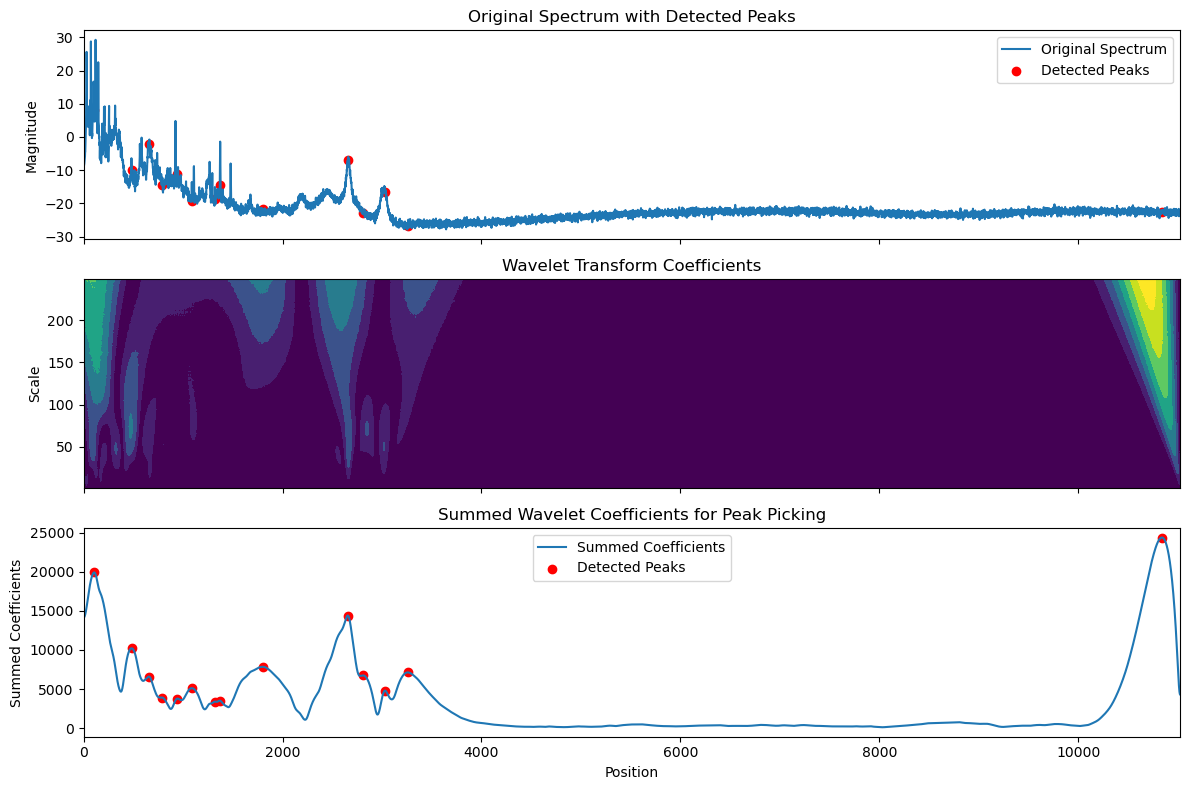

Detected peak positions: [  106.32019043   481.80541992   656.76269531   784.61608887
   943.42346191  1086.08093262  1321.6003418   1368.70422363
  1799.36828613  2655.31311035  2808.73718262  3030.79833984
  3258.24279785 10841.96777344]


In [75]:
# 1D Summed Coefficient Peak Picking

# Wavelet transform
wavelet = 'mexh'  # Mexican Hat wavelet, good for peak detection
scales = np.arange(1, 250)  # Choose scales based on expected peak widths
coefficients, frequencies = pywt.cwt(spectrum, scales, wavelet)

# Take the absolute value of the coefficients
coefficients = np.abs(coefficients)

# Sum across scales to enhance peak prominence
summed_coefficients = np.sum(coefficients, axis=0)

# Smooth the summed coefficients with gaussian filter
sigma = 10
summed_coefficients = gaussian_filter1d(summed_coefficients, sigma)

# Find peaks using scipy.signal.find_peaks
peaks, properties = find_peaks(summed_coefficients, height=1000, distance=10)

# Plot the results
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Original spectrum with detected peaks
axes[0].plot(f, spectrum, label="Original Spectrum")
axes[0].scatter(f[peaks], spectrum[peaks], color='red', label="Detected Peaks")
axes[0].set_title("Original Spectrum with Detected Peaks")
axes[0].set_ylabel("Magnitude")
axes[0].legend()

# Wavelet coefficients heatmap
c = axes[1].contourf(f, scales, coefficients, extend='both', cmap='viridis')
axes[1].set_title("Wavelet Transform Coefficients")
axes[1].set_ylabel("Scale")
# fig.colorbar(c, ax=axes[1], label="Coefficient Magnitude")

# Summed coefficients and detected peaks
axes[2].plot(f, summed_coefficients, label="Summed Coefficients")
axes[2].scatter(f[peaks], summed_coefficients[peaks], color='red', label="Detected Peaks")
axes[2].set_title("Summed Wavelet Coefficients for Peak Picking")
axes[2].set_xlabel("Position")
axes[2].set_ylabel("Summed Coefficients")
axes[2].legend()

plt.tight_layout()
plt.show()

# Print detected peak positions
print("Detected peak positions:", f[peaks])


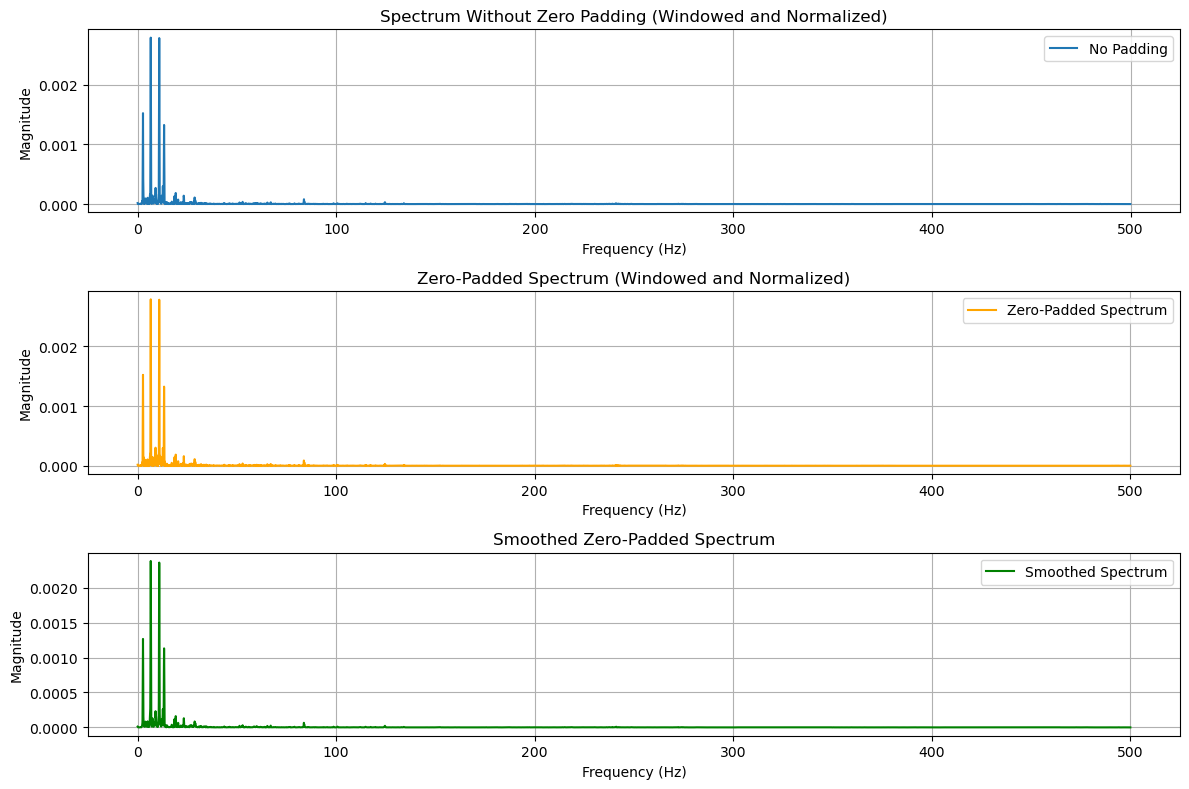

In [56]:
# Apply a window (Hanning) and normalize
window = np.hanning(len(time_domain_signal))
normalized_window = window / np.sum(window)  # Normalize for FFT consistency
windowed_signal = time_domain_signal * normalized_window

# Perform FFT without zero padding
fft_no_padding = np.fft.fft(windowed_signal)
freq_no_padding = np.fft.fftfreq(len(windowed_signal), d=1/fs)

# Zero pad the windowed signal
zero_padding_factor = 4  # Zero padding factor
zero_padded_signal = np.pad(windowed_signal, (0, int((zero_padding_factor - 1) * len(windowed_signal))), 'constant')
fft_zero_padded = np.fft.fft(zero_padded_signal)
freq_zero_padded = np.fft.fftfreq(len(zero_padded_signal), d=1/fs)

# Smooth the spectrum (optional)
smoothed_spectrum = gaussian_filter1d(np.abs(fft_zero_padded), sigma=2)

# Plot spectra
plt.figure(figsize=(12, 8))

# Original spectrum (no padding)
plt.subplot(3, 1, 1)
plt.plot(freq_no_padding[:len(freq_no_padding)//2], np.abs(fft_no_padding)[:len(freq_no_padding)//2], label="No Padding")
plt.title("Spectrum Without Zero Padding (Windowed and Normalized)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()

# Zero-padded spectrum
plt.subplot(3, 1, 2)
plt.plot(freq_zero_padded[:len(freq_zero_padded)//2], np.abs(fft_zero_padded)[:len(freq_zero_padded)//2], label="Zero-Padded Spectrum", color="orange")
plt.title("Zero-Padded Spectrum (Windowed and Normalized)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()

# Smoothed zero-padded spectrum
plt.subplot(3, 1, 3)
plt.plot(freq_zero_padded[:len(freq_zero_padded)//2], smoothed_spectrum[:len(freq_zero_padded)//2], label="Smoothed Spectrum", color="green")
plt.title("Smoothed Zero-Padded Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

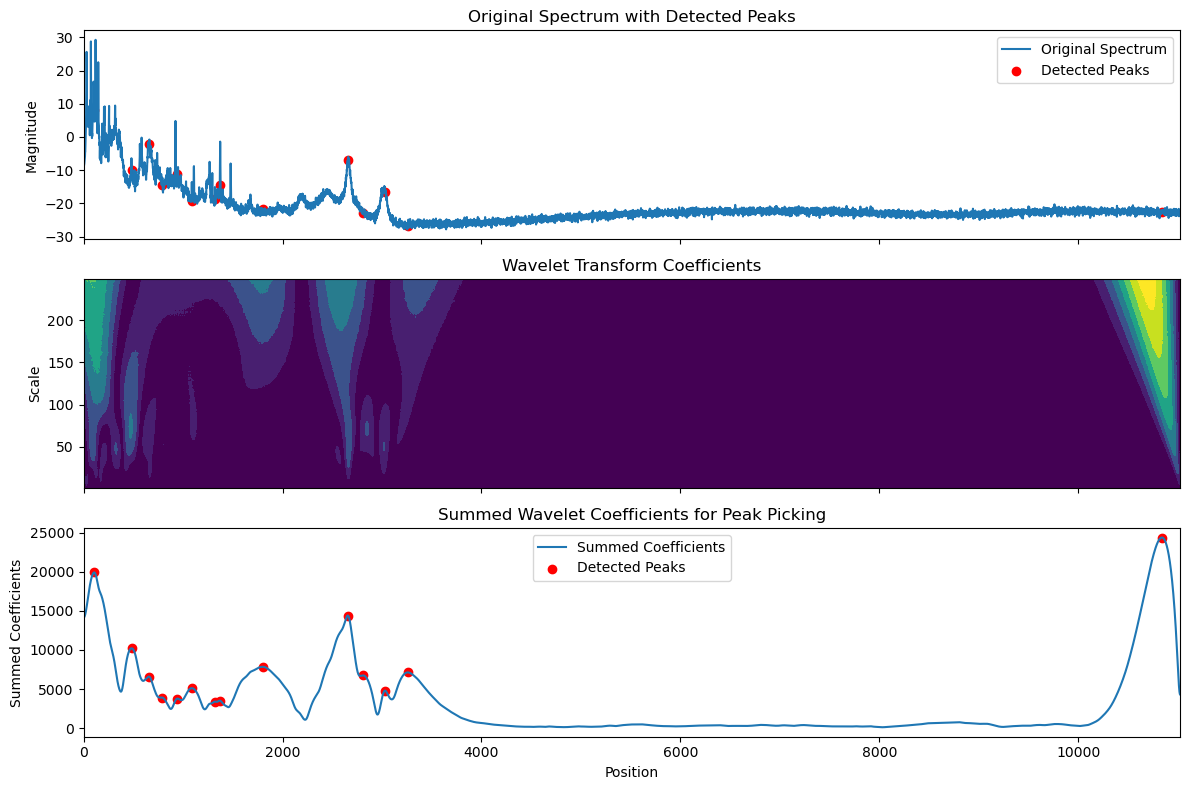

Detected peak positions: [  106.32019043   481.80541992   656.76269531   784.61608887
   943.42346191  1086.08093262  1321.6003418   1368.70422363
  1799.36828613  2655.31311035  2808.73718262  3030.79833984
  3258.24279785 10841.96777344]


In [39]:
# 1D Summed Coefficient Peak Picking

# Wavelet transform
wavelet = 'mexh'  # Mexican Hat wavelet, good for peak detection
scales = np.arange(1, 250)  # Choose scales based on expected peak widths
coefficients, frequencies = pywt.cwt(spectrum, scales, wavelet)

# Take the absolute value of the coefficients
coefficients = np.abs(coefficients)

# Sum across scales to enhance peak prominence
summed_coefficients = np.sum(coefficients, axis=0)

# Smooth the summed coefficients with gaussian filter
sigma = 10
summed_coefficients = gaussian_filter1d(summed_coefficients, sigma)

# Find peaks using scipy.signal.find_peaks
peaks, properties = find_peaks(summed_coefficients, height=1000, distance=10)

# Plot the results
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Original spectrum with detected peaks
axes[0].plot(f, spectrum, label="Original Spectrum")
axes[0].scatter(f[peaks], spectrum[peaks], color='red', label="Detected Peaks")
axes[0].set_title("Original Spectrum with Detected Peaks")
axes[0].set_ylabel("Magnitude")
axes[0].legend()

# Wavelet coefficients heatmap
c = axes[1].contourf(f, scales, coefficients, extend='both', cmap='viridis')
axes[1].set_title("Wavelet Transform Coefficients")
axes[1].set_ylabel("Scale")
# fig.colorbar(c, ax=axes[1], label="Coefficient Magnitude")

# Summed coefficients and detected peaks
axes[2].plot(f, summed_coefficients, label="Summed Coefficients")
axes[2].scatter(f[peaks], summed_coefficients[peaks], color='red', label="Detected Peaks")
axes[2].set_title("Summed Wavelet Coefficients for Peak Picking")
axes[2].set_xlabel("Position")
axes[2].set_ylabel("Summed Coefficients")
axes[2].legend()

plt.tight_layout()
plt.show()

# Print detected peak positions
print("Detected peak positions:", f[peaks])


In [10]:
# 2D persistent homology wavelet coefficient peak picking
fmax_index = 500
spectrum = spectrum[0:fmax_index]
f = f[0:fmax_index]

[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [3].
[findpeaks] >Detect peaks using topology method with limit at 0.
[findpeaks] >Detect peaks using topology method with limit at 0.
[findpeaks] >Fin.


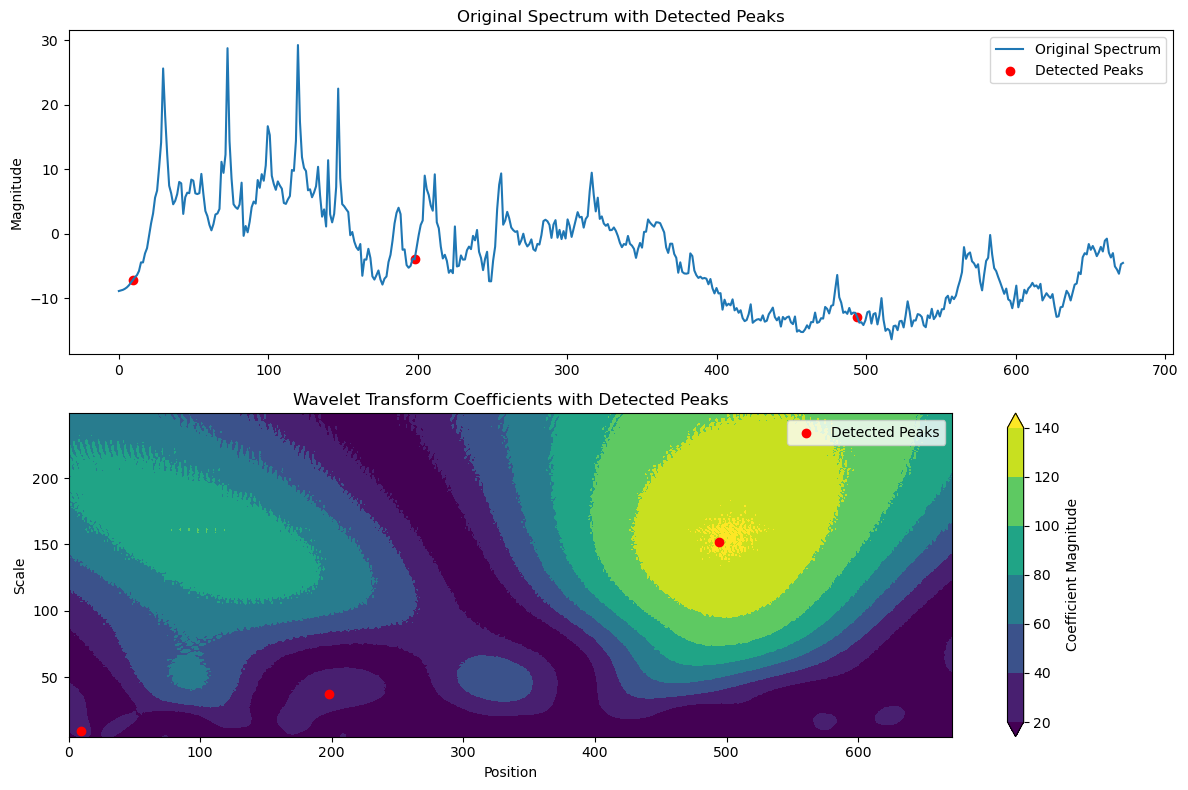

Detected peak at position: 9.42, scale: 9.00
Detected peak at position: 197.84, scale: 37.00
Detected peak at position: 493.92, scale: 152.00


In [12]:
# 2D Persistent Homology Wavelet Coefficient Peak Picking
max_persistence = 50

# Wavelet transform
wavelet = 'mexh'  # Mexican Hat wavelet, good for peak detection
scales = np.arange(5, 250, 1)  # Choose scales based on expected peak widths
coefficients, frequencies = pywt.cwt(spectrum, scales, wavelet)

# Take the absolute value of the coefficients
coefficients = np.abs(coefficients)

# Find peaks using the findpeaks library
fp = findpeaks(method='topology')
results = fp.fit(coefficients)

# Get peak coordinates and create a binary peak positions matrix
peaks_2d = results['Xdetect']
peak_positions_binary = (peaks_2d > max_persistence).astype(int)  # Convert non-zero values to 1, others to 0

# Plot the results
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

# Original spectrum with detected peaks
axes[0].plot(f, spectrum, label="Original Spectrum")
if np.any(peak_positions_binary):
    peak_positions_f = f[np.where(peak_positions_binary.sum(axis=0) > 0)]
    axes[0].scatter(peak_positions_f, spectrum[np.searchsorted(f, peak_positions_f)], color='red', label="Detected Peaks")
axes[0].set_title("Original Spectrum with Detected Peaks")
axes[0].set_ylabel("Magnitude")
axes[0].legend()

# Wavelet coefficients heatmap with detected peaks
c = axes[1].contourf(f, scales, coefficients, extend='both', cmap='viridis')
if np.any(peak_positions_binary):
    peak_indices = np.argwhere(peak_positions_binary == 1)
    axes[1].scatter(f[peak_indices[:, 1]], scales[peak_indices[:, 0]], color='red', label="Detected Peaks")
axes[1].set_title("Wavelet Transform Coefficients with Detected Peaks")
axes[1].set_ylabel("Scale")
axes[1].set_xlabel("Position")
fig.colorbar(c, ax=axes[1], label="Coefficient Magnitude")
axes[1].legend()

plt.tight_layout()
plt.show()

# Print detected peak positions and scales if there are any
if np.any(peak_positions_binary):
    for scale, pos in zip(scales[peak_indices[:, 0]], f[peak_indices[:, 1]]):
        print(f"Detected peak at position: {pos:.2f}, scale: {scale:.2f}")
else:
    print("No peaks detected.")


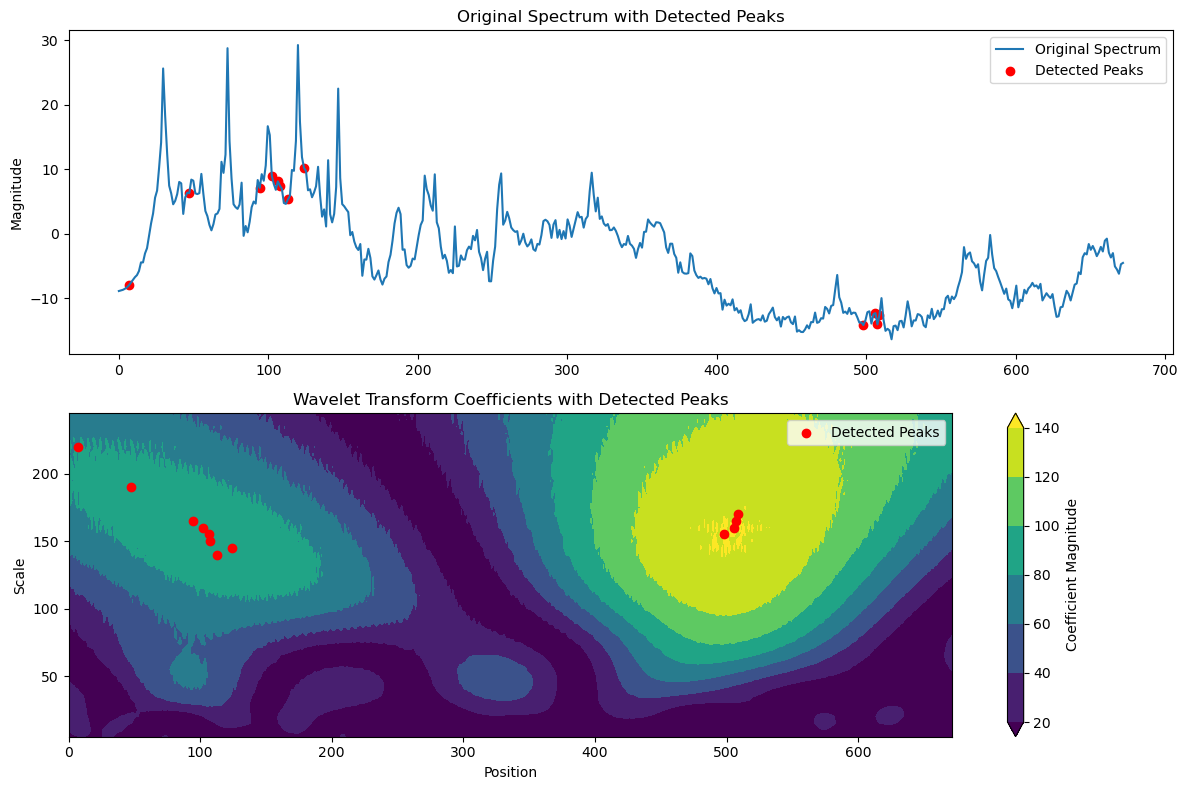

Detected peak at position: 113.05, scale: 140.00
Detected peak at position: 123.82, scale: 145.00
Detected peak at position: 107.67, scale: 150.00
Detected peak at position: 106.32, scale: 155.00
Detected peak at position: 497.96, scale: 155.00
Detected peak at position: 102.28, scale: 160.00
Detected peak at position: 506.03, scale: 160.00
Detected peak at position: 94.21, scale: 165.00
Detected peak at position: 507.38, scale: 165.00
Detected peak at position: 508.72, scale: 170.00
Detected peak at position: 47.10, scale: 190.00
Detected peak at position: 6.73, scale: 220.00


In [13]:
# 2D Persistent Homology Wavelet Coefficient Peak Picking

# Wavelet transform
wavelet = 'mexh'  # Mexican Hat wavelet, good for peak detection
scales = np.arange(5, 250, 5)  # Choose scales based on expected peak widths
coefficients, frequencies = pywt.cwt(spectrum, scales, wavelet)

# Take the absolute value of the coefficients
coefficients = np.abs(coefficients)

# Find peaks in each row (along scales) and each column (along positions)
from scipy.signal import find_peaks

# Threshold for minimum peak height
min_height = -10
min_distance = 100
min_prominence = 10

# Find peaks in each row
row_peaks = [find_peaks(row, height=min_height, prominence=min_prominence, distance=min_distance)[0] for row in coefficients]

# Find peaks in each column
col_peaks = [find_peaks(coefficients[:, i], height=min_height, prominence=min_prominence, distance=min_distance)[0] for i in range(coefficients.shape[1])]

# Combine row and column peaks to find 2D peaks
peak_positions_binary = np.zeros_like(coefficients, dtype=int)
for i, peaks in enumerate(row_peaks):
    for peak in peaks:
        if i in col_peaks[peak]:
            peak_positions_binary[i, peak] = 1

# Plot the results
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

# Original spectrum with detected peaks
axes[0].plot(f, spectrum, label="Original Spectrum")
if np.any(peak_positions_binary):
    peak_positions_f = f[np.where(peak_positions_binary.sum(axis=0) > 0)]
    axes[0].scatter(peak_positions_f, spectrum[np.searchsorted(f, peak_positions_f)], color='red', label="Detected Peaks")
axes[0].set_title("Original Spectrum with Detected Peaks")
axes[0].set_ylabel("Magnitude")
axes[0].legend()

# Wavelet coefficients heatmap with detected peaks
c = axes[1].contourf(f, scales, coefficients, extend='both', cmap='viridis')
if np.any(peak_positions_binary):
    peak_indices = np.argwhere(peak_positions_binary == 1)
    axes[1].scatter(f[peak_indices[:, 1]], scales[peak_indices[:, 0]], color='red', label="Detected Peaks")
axes[1].set_title("Wavelet Transform Coefficients with Detected Peaks")
axes[1].set_ylabel("Scale")
axes[1].set_xlabel("Position")
fig.colorbar(c, ax=axes[1], label="Coefficient Magnitude")
axes[1].legend()

plt.tight_layout()
plt.show()

# Print detected peak positions and scales if there are any
if np.any(peak_positions_binary):
    for scale, pos in zip(scales[peak_indices[:, 0]], f[peak_indices[:, 1]]):
        print(f"Detected peak at position: {pos:.2f}, scale: {scale:.2f}")
else:
    print("No peaks detected.")


In [ ]:
double_spectrum = rfft(spectrum)
cutoff = 100
double_spectrum[cutoff:] = np.zeros(len(double_spectrum[cutoff:]), dtype=complex)
filtered_spectrum = irfft(double_spectrum)
plt.plot(f, filtered_spectrum)